Working on the Post-training quantization of the model and the subset of the dataset. 
* Working on the model already trained with the CMS dataset.
* The model has been quantized using the `tf.lite.converter`
* Further, we are working with sample of the dataset(100 for our case). 
* Quantizing the sample of dataset using INT8 quantization


As written on here, we were working on the stuff with the debugging of the model and working out the task. 
* Perform the quantization of the model
* Convert all of the data 
* Put all stuff in a notebook along with the model interface.

## `Task`
Standardize the P_T value before quantizing.

Three P_T plots:

Raw P_T (Number of particles vs P_T (GeV))
P_T after standardization (X-axis should be arbitrary units)
After int8 quantization. Centers at 0 and range should be between -127, 127)
Upon standardization, there could be a few values which could be out of the range of (-127, 127). How to deal with the outliers? One of the methods is to put all of them in the last bin. Are there any other methods available?

Fix bin size does not give resolution. We can lose information if we discard those outliers.

Print the true and predicted P_T values. Should be in the INT8 range.

Put on the distribution if it makes sense.

We need to standradization to whole datasample which is 100 in our case.
* Plot the datasample before and after standradization ??
* Or do we only need to standradize the True P_T?
* What type of output you have right now?

`The dataset contains input features and target features consist of different things like pT, eta, phi etc. so all of those need to be standardized and quantized separately. but you can start with just pT` Task:

1. Since working only on the pT, quntize it after standradization. Further Check the plots before and after quantization.

Quantize the dataset after stnadradization and then do the inference. Check the output plots

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pathlib

import ROOT 

2024-01-23 15:49:58.395755: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Welcome to JupyROOT 6.30/02


In [2]:
import sys 
sys.path += ["../../../MLPF/mlpf/particleflow/mlpf/"]
from tfmodel.model_setup import make_model
from tfmodel.utils import parse_config

In [3]:
config, _ = parse_config("../../../MLPF/mlpf/particleflow/parameters/clic.yaml") #positions on the lxplus


In [4]:

model = make_model(config, tf.float32)
model.build((1, None, config["dataset"]["num_input_features"]))

In [5]:
model.summary()

Model: "pf_net_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 node_encoding (Sequential)  (1, None, 256)            70912     
                                                                 
 input_encoding_clic (Input  multiple                  0         
 EncodingCLIC)                                                   
                                                                 
 cg_id_0 (CombinedGraphLaye  multiple                  440128    
 r)                                                              
                                                                 
 cg_id_1 (CombinedGraphLaye  multiple                  440128    
 r)                                                              
                                                                 
 cg_id_2 (CombinedGraphLaye  multiple                  440128    
 r)                                                   

In [6]:
model.load_weights("weights-96-5.346523.hdf5", skip_mismatch=False, by_name=True)
## These files hosted at https://huggingface.co/jpata/particleflow/tree/clic_clusters_v1.6

In [7]:
## Reading the dataset
ds_builder = tfds.builder("clic_edm_qq_pf", data_dir = '../../../MLPF/mlpf/tensorflow_datasets/') # Tensorflow datsets positions in the lxplus
dss = ds_builder.as_data_source("test")

In [8]:
def yield_from_ds():
    for elem in dss:
        yield {"X": elem["X"], "ygen": elem["ygen"], "ycand": elem["ycand"]}

In [9]:
output_signature = {k: tf.TensorSpec(shape=(None, v.shape[1])) for (k, v) in dss.dataset_info.features.items()}
tf_dataset = tf.data.Dataset.from_generator(yield_from_ds, output_signature=output_signature).take(100).padded_batch(batch_size=10)

In [10]:
data = list(tfds.as_numpy(tf_dataset))


In [11]:
Xs = [d["X"] for d in data]
ys = [d["ygen"] for d in data]
ycs= [d["ycand"] for d in data]

In [12]:
true_pts = []
pred_pts = []

for ibatch in range(len(Xs)):
    ret = model(Xs[ibatch])

    mask_true_particles = ys[ibatch][..., 0]!=0
    
    true_pt = ys[ibatch][mask_true_particles, 2]
    pred_pt = ret["pt"][mask_true_particles][..., 0].numpy()

    true_pts.append(true_pt)
    pred_pts.append(pred_pt)

In [13]:
true_pt = np.concatenate(true_pts)
pred_pt = np.concatenate(pred_pts)

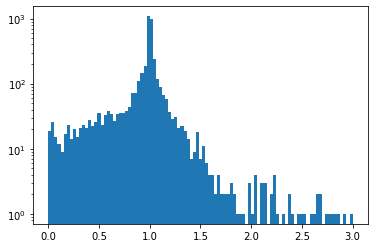

In [14]:

plt.hist(pred_pt/true_pt, bins=np.linspace(0,3,100));
plt.yscale("log")

Task:-
1. Standradize the input(why?)
2. Further quantize the dataset and quantize the model.
3. Measure the inference.

In [15]:
true_pts_ygen = np.concatenate([d["ygen"][:, 2] for d in data])
true_pts_ycand = np.concatenate([d["ycand"][:, 2] for d in data])

In [16]:

print("True pt from ygen:", true_pts_ygen)
print("True pt from ycand:", true_pts_ycand)

True pt from ygen: [[ 1.00000000e+00 -1.00000000e+00  3.91250396e+00  8.51751029e-01
  -9.60166156e-01  2.79429704e-01  5.42142534e+00  1.00000000e+00]
 [ 1.00000000e+00 -1.00000000e+00  3.57476068e+00 -2.25394058e+00
   9.75725949e-01 -2.18995124e-01  1.72133617e+01  1.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  1.27688611e+00  2.29832387e+00
   2.75673121e-01  9.61251438e-01  6.42291737e+00  2.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  6.18536758e+00 -1.85006022e+00
   8.25993717e-01  5.63679338e-01  2.01781788e+01  2.00000000e+00]
 [ 1.00000000e+00 -1.00000000e+00  9.67933083e+00 -8.46591949e-01
  -8.92565370e-01 -4.50918049e-01  1.33609200e+01  3.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  8.60886192e+00  2.34120822e+00
  -7.80091345e-01 -6.25665665e-01  4.51536942e+01  2.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  3.38208795e+00 -4.95963007e-01
   9.03786659e-01 -4.27983284e-01  3.80920434e+00  1.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  6.98776913e+00 

In [17]:
print(true_pts_ygen.shape)
print(true_pts_ycand.shape)

(100, 8)
(100, 8)


In [18]:
flat_true_pts_ygen = true_pts_ygen.flatten()
flat_true_pts_ycand = true_pts_ycand.flatten()

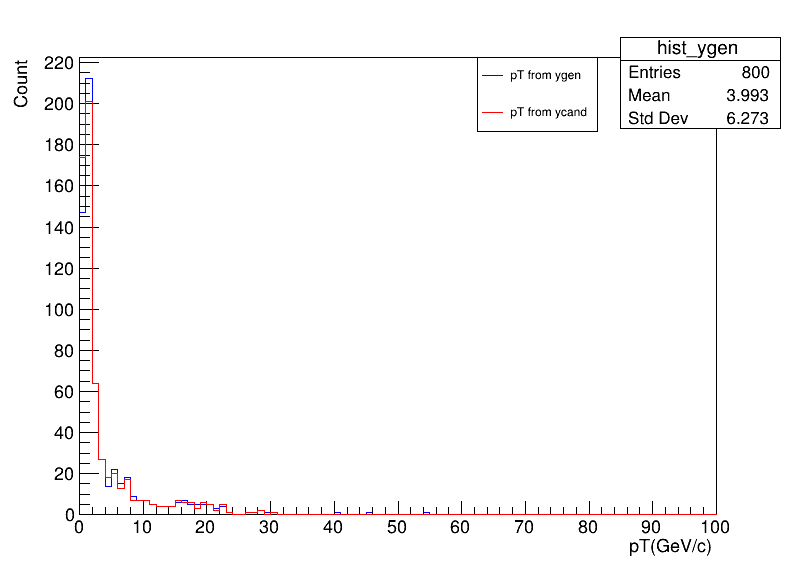

In [19]:
hist_ygen = ROOT.TH1F("hist_ygen", "True pT from ygen", 100, 0, 100)
hist_ycand = ROOT.TH1F("hist_ycand", "True pT from ycand", 100, 0, 100)


# Fill histograms with 'pt' values
for value in flat_true_pts_ygen:
    hist_ygen.Fill(value)

for value in flat_true_pts_ycand:
    hist_ycand.Fill(value)

    
canvas = ROOT.TCanvas("canvas", "True pt Comparison", 800, 600)

hist_ygen.Draw()
hist_ygen.SetTitle("")
hist_ygen.SetLineColor(ROOT.kBlue)
hist_ygen.GetXaxis().SetTitle("pT(GeV/c)")
hist_ygen.GetYaxis().SetTitle("Count")

hist_ycand.Draw("SAME")
hist_ycand.SetLineColor(ROOT.kRed)
  
legend = ROOT.TLegend(0.6, 0.77, 0.75, 0.9)
legend.AddEntry(hist_ygen, " pT from ygen", "l")
legend.AddEntry(hist_ycand, " pT from ycand", "l")
legend.Draw("SAME")

canvas.Draw()


## Standardize `pT` values



In [20]:
mean_ygen = np.mean(flat_true_pts_ygen)
std_ygen = np.std(flat_true_pts_ygen)

standardized_true_pts_ygen = (flat_true_pts_ygen - mean_ygen) / std_ygen

mean_ycand = np.mean(flat_true_pts_ycand)
std_ycand = np.std(flat_true_pts_ycand)

standardized_true_pts_ycand = (flat_true_pts_ycand - mean_ycand) / std_ycand

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


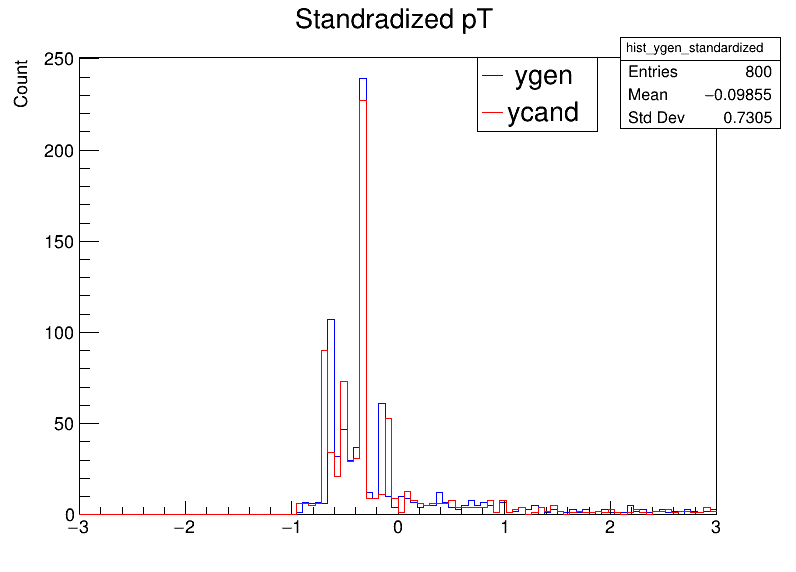

In [21]:
hist_ygen_standardized = ROOT.TH1F("hist_ygen_standardized", "Standardized True pt from ygen", 100, -3, 3)
hist_ycand_standardized = ROOT.TH1F("hist_ycand_standardized", "Standardized True pt from ycand", 100, -3, 3)

for value in standardized_true_pts_ygen:
    hist_ygen_standardized.Fill(value)

for value in standardized_true_pts_ycand:
    hist_ycand_standardized.Fill(value)
    
    
canvas = ROOT.TCanvas("canvas", "True pt Comparison", 800, 600)

hist_ygen_standardized.Draw()
hist_ygen_standardized.SetTitle("Standradized pT")
hist_ygen_standardized.SetLineColor(ROOT.kBlue)
# hist_ygen_standardized.GetXaxis().SetTitle("pT(GeV/c)")
hist_ygen_standardized.GetYaxis().SetTitle("Count")

hist_ycand_standardized.Draw("SAME")
hist_ycand_standardized.SetLineColor(ROOT.kRed)
  
legend = ROOT.TLegend(0.6, 0.77, 0.75, 0.9)
legend.AddEntry(hist_ygen, " ygen", "l")
legend.AddEntry(hist_ycand, "ycand ", "l")
legend.Draw("SAME")

canvas.Draw()

quantizing the input data

In [22]:
scale_factor_ygen = np.max(np.abs(standardized_true_pts_ygen)) / 127.0
quantized_true_pts_ygen = (standardized_true_pts_ygen / scale_factor_ygen).astype(np.int8)

scale_factor_ycand = np.max(np.abs(standardized_true_pts_ycand)) / 127.0
quantized_true_pts_ycand = (standardized_true_pts_ycand / scale_factor_ycand).astype(np.int8)


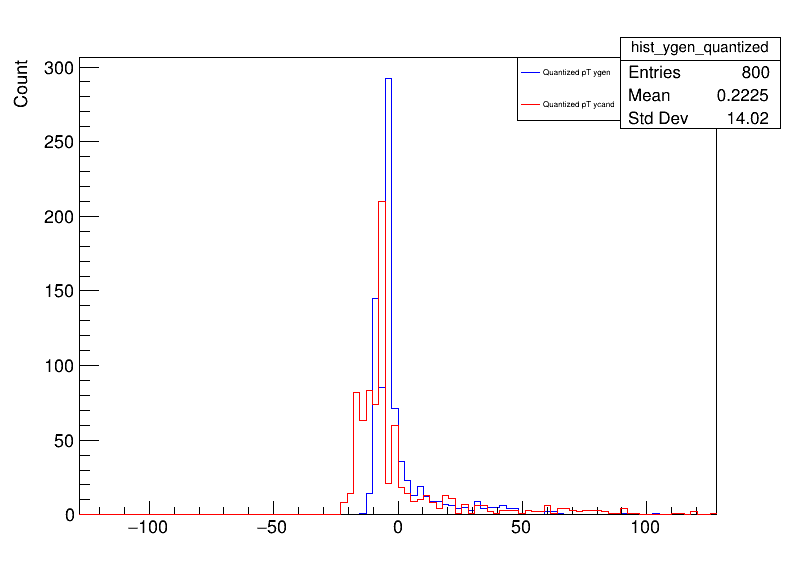

In [23]:
hist_ygen_quantized = ROOT.TH1F("hist_ygen_quantized", "", 100, -128, 128)
hist_ycand_quantized = ROOT.TH1F("hist_ycand_quantized", "Quantized Standardized True pt from ycand", 100, -128, 128)

# Fill histograms with quantized standardized 'pt' values
for value in quantized_true_pts_ygen:
    hist_ygen_quantized.Fill(value)

for value in quantized_true_pts_ycand:
    hist_ycand_quantized.Fill(value)
    
    
# Create canvas and draw histograms
canvas_quantized = ROOT.TCanvas("canvas_quantized", "Quantized Standardized True pt Comparison", 800, 600)

hist_ygen_quantized.Draw()
# hist_ygen_quantized.SetTitle("Quantized Standardized True pt Comparison")
hist_ygen_quantized.SetLineColor(ROOT.kBlue)
# hist_ygen_quantized.GetXaxis().SetTitle("Quantized pt")
hist_ygen_quantized.GetYaxis().SetTitle("Count")

hist_ycand_quantized.Draw("SAME")
hist_ycand_quantized.SetLineColor(ROOT.kRed)

# Add a legend
legend_quantized = ROOT.TLegend(0.65, 0.79, 0.78, 0.9)
legend_quantized.AddEntry(hist_ygen_quantized, "Quantized pT ygen", "l")
legend_quantized.AddEntry(hist_ycand_quantized, "Quantized pT ycand", "l")
legend_quantized.Draw("SAME")

# Show the canvas
canvas_quantized.Draw()

Quantizing the model

**Questions**
1. Which type of quantization we need to do?
2. Which is the best quantization for the dataset?
3. How can we use the inference and measure it?


We can start with the Post-training dynamic range quantization and then if can get success we can move to integer quantization and float16 quantization.

Using the TensorFlow Lite Converter, you can now convert the trained model into a TensorFlow Lite model.



In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


2024-01-23 15:52:28.514925: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-01-23 15:52:28.514968: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-01-23 15:52:28.515423: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/sraj/tmph7549bm6
2024-01-23 15:52:28.560077: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-01-23 15:52:28.560126: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/sraj/tmph7549bm6
2024-01-23 15:52:28.683551: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-01-23 15:52:28.740149: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-01-23 15:52:29.363482: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/sraj/tmph

Write it out to a tflite file:



In [25]:
tflite_models_dir = pathlib.Path("/tmp/working1_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [26]:
tflite_model_file = tflite_models_dir/"working1_tflite_models.tflite"
tflite_model_file.write_bytes(tflite_model)

22305380

To quantize the model on export, set the optimizations flag to optimize for size:



In [27]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"working_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

5963072

2024-01-23 15:53:24.823999: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-01-23 15:53:24.824046: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-01-23 15:53:24.824459: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/sraj/tmpcf8thm7p
2024-01-23 15:53:24.956857: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-01-23 15:53:24.956911: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/sraj/tmpcf8thm7p
2024-01-23 15:53:25.225228: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-01-23 15:53:25.845076: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/sraj/tmpcf8thm7p
2024-01-23 15:53:26.270379: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: O

Note how the resulting file, is approximately 1/4 the size.



In [28]:
ls -lh {tflite_models_dir}

total 27M
-rw-r--r--. 1 sraj zh  22M Jan 23 15:52 working1_tflite_models.tflite
-rw-r--r--. 1 sraj zh 5.7M Jan 23 15:53 working_model_quant.tflite


Task is to run the TFLite models

In [29]:
# Load the model into an interpreter
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [30]:
interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()

Test the model on the quantized data 

https://www.tensorflow.org/lite/performance/post_training_quant

In [31]:
# Load the quantized model into an interpreter
interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()


In [32]:
#Print Expected Input Shape:
print("Expected Input Shape:", interpreter_quant.get_input_details()[0]['shape'])


Expected Input Shape: [  1 111  17]


In [38]:
# Placeholder for input and output tensor indices
input_tensor_index = 0  # Replace with the actual input tensor index
output_tensor_index = 0  # Replace with the actual output tensor index

quantized_true_pts_ygen = []  # List to store true quantized pT values from ygen
quantized_pred_pts_ygen = []  # List to store predicted quantized pT values from ygen

quantized_true_pts_ycand = []  # List to store true quantized pT values from ycand
quantized_pred_pts_ycand = []  # List to store predicted quantized pT values from ycand

# Function to dequantize the output tensor
def dequantize(tensor, scale_factor, dtype=np.float32):
    # Implement your dequantization logic here
    # Example: dequantized_tensor = tensor * scale_factor
    pass

In [40]:
# Inference loop for ygen
for ibatch in range(len(Xs)):
    interpreter_quant.set_tensor(input_tensor_index, quantized_true_pts_ygen[ibatch])  # Corrected line
    interpreter_quant.invoke()
    quantized_ret_ygen = interpreter_quant.get_tensor(output_tensor_index)
    dequantized_pred_pt_ygen = dequantize(quantized_ret_ygen, scale_factor_ygen, dtype=np.float32)
    quantized_true_pts_ygen.append(quantized_true_pt)
    quantized_pred_pts_ygen.append(dequantized_pred_pt_ygen)

IndexError: list index out of range

In [ ]:
# Flatten the lists
true_pts_quantized_flat = np.concatenate(true_pts_quantized)
pred_pts_quantized_flat = np.concatenate(pred_pts_quantized)

# Plot the histogram of predicted/true pT ratio from quantized inference
plt.hist(pred_pts_quantized_flat / true_pts_quantized_flat, bins=np.linspace(0, 3, 100))
plt.yscale("log")
plt.xlabel("Predicted True Pt Ratio (Quantized Inference)")
plt.ylabel("Count")
plt.title("Histogram of Predicted True Pt Ratio from Quantized Inference")
plt.show()


Above is done for a smaller dataset sample of 100 for the quantization. We only played with pT, we have another variables as well.
Task:
1. Try to work with more number of samples.
2. Try to work with different Variables.
3. Try with different model quantization

In [ ]:
## For Eta as the variable

In [18]:
true_pts = []
pred_pts = []

for ibatch in range(len(Xs)):
    ret = model(Xs[ibatch])

    mask_true_particles = ys[ibatch][..., 0]!=0
    
    true_pt = ys[ibatch][mask_true_particles, 3]
    pred_pt = ret["eta"][mask_true_particles][..., 0].numpy()

    true_pts.append(true_pt)
    pred_pts.append(pred_pt)

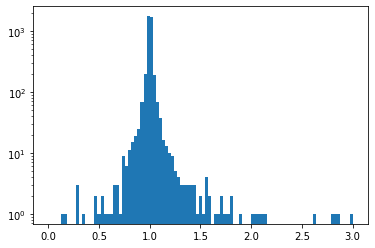

In [19]:
true_pt = np.concatenate(true_pts)
pred_pt = np.concatenate(pred_pts)
plt.hist(pred_pt/true_pt, bins=np.linspace(0,3,100));
plt.yscale("log")

In [26]:
true_etas_ygen = np.concatenate([d["ygen"][:, 3] for d in data])
true_etas_ycand = np.concatenate([d["ycand"][:, 3] for d in data])

In [27]:

print("True eta from ygen:", true_etas_ygen)
print("True eta from ycand:", true_etas_ycand)

True eta from ygen: [[ 1.00000000e+00 -1.00000000e+00  1.00993001e+00  4.49878037e-01
  -1.43312663e-01  9.89677489e-01  1.12257564e+00  2.00000000e+00]
 [ 1.00000000e+00 -1.00000000e+00  2.42714381e+00  2.29693890e+00
  -7.16479957e-01  6.97607636e-01  1.21994286e+01  2.00000000e+00]
 [ 1.00000000e+00 -1.00000000e+00  1.86482263e+00 -1.32520616e+00
   9.37190115e-01 -3.48818988e-01  3.78871560e+00  1.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  4.06357718e+00 -9.96410012e-01
   1.52879087e-02 -9.99883115e-01  6.25488043e+00  1.00000000e+00]
 [ 1.00000000e+00 -1.00000000e+00  8.13341713e+00 -8.91916275e-01
  -9.09296036e-01 -4.16149884e-01  1.16266985e+01  3.00000000e+00]
 [ 1.00000000e+00 -1.00000000e+00  3.51024580e+00  2.34390092e+00
  -8.27127099e-01 -5.62014878e-01  1.84665680e+01  2.00000000e+00]
 [ 1.00000000e+00 -1.00000000e+00  3.12702346e+00 -1.20095491e+00
   2.81671405e-01  9.59510922e-01  5.68793726e+00  3.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  4.12706280e+00

In [28]:
print(true_etas_ygen.shape)
print(true_etas_ycand.shape)

(100, 8)
(100, 8)


In [29]:
flat_true_etas_ygen = true_etas_ygen.flatten()
flat_true_etas_ycand = true_etas_ycand.flatten()

Warning in <TROOT::Append>: Replacing existing TH1: hist_ygen (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_ycand (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


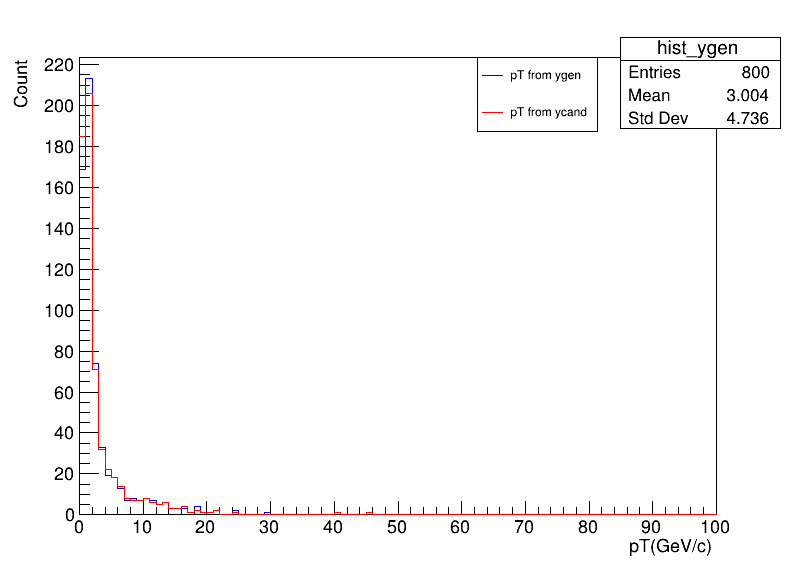

In [30]:
hist_ygen = ROOT.TH1F("hist_ygen", "True pT from ygen", 100, 0, 100)
hist_ycand = ROOT.TH1F("hist_ycand", "True pT from ycand", 100, 0, 100)


# Fill histograms with 'pt' values
for value in flat_true_etas_ygen:
    hist_ygen.Fill(value)

for value in flat_true_etas_ycand:
    hist_ycand.Fill(value)

    
canvas = ROOT.TCanvas("canvas", "True pt Comparison", 800, 600)

hist_ygen.Draw()
hist_ygen.SetTitle("")
hist_ygen.SetLineColor(ROOT.kBlue)
hist_ygen.GetXaxis().SetTitle("pT(GeV/c)")
hist_ygen.GetYaxis().SetTitle("Count")

hist_ycand.Draw("SAME")
hist_ycand.SetLineColor(ROOT.kRed)
  
legend = ROOT.TLegend(0.6, 0.77, 0.75, 0.9)
legend.AddEntry(hist_ygen, " pT from ygen", "l")
legend.AddEntry(hist_ycand, " pT from ycand", "l")
legend.Draw("SAME")

canvas.Draw()


### Standradize `eta` values

In [31]:
mean_ygen = np.mean(flat_true_etas_ygen)
std_ygen = np.std(flat_true_etas_ygen)

standardized_true_pts_ygen = (flat_true_etas_ygen - mean_ygen) / std_ygen

mean_ycand = np.mean(flat_true_etas_ycand)
std_ycand = np.std(flat_true_etas_ycand)

standardized_true_pts_ycand = (flat_true_etas_ycand - mean_ycand) / std_ycand

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


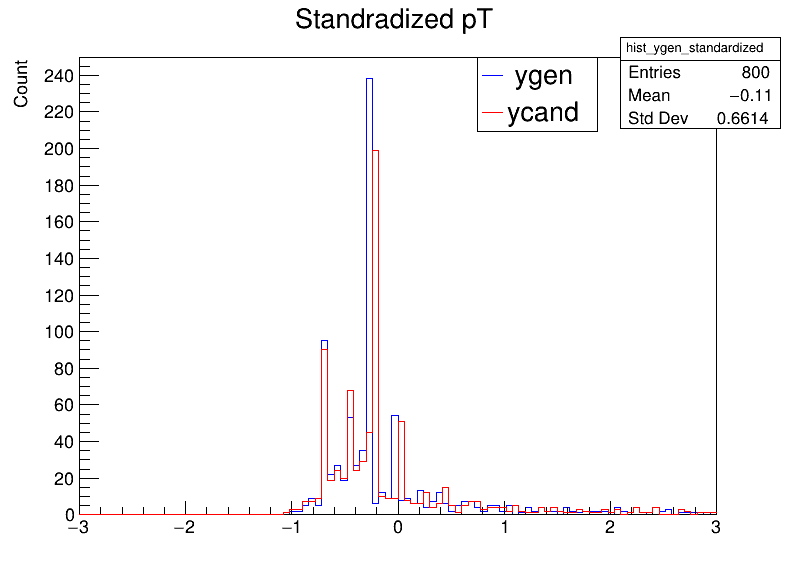

In [32]:
hist_ygen_standardized = ROOT.TH1F("hist_ygen_standardized", "Standardized True pt from ygen", 100, -3, 3)
hist_ycand_standardized = ROOT.TH1F("hist_ycand_standardized", "Standardized True pt from ycand", 100, -3, 3)

for value in standardized_true_pts_ygen:
    hist_ygen_standardized.Fill(value)

for value in standardized_true_pts_ycand:
    hist_ycand_standardized.Fill(value)
    
    
canvas = ROOT.TCanvas("canvas", "True pt Comparison", 800, 600)

hist_ygen_standardized.Draw()
hist_ygen_standardized.SetTitle("Standradized pT")
hist_ygen_standardized.SetLineColor(ROOT.kBlue)
# hist_ygen_standardized.GetXaxis().SetTitle("pT(GeV/c)")
hist_ygen_standardized.GetYaxis().SetTitle("Count")

hist_ycand_standardized.Draw("SAME")
hist_ycand_standardized.SetLineColor(ROOT.kRed)
  
legend = ROOT.TLegend(0.6, 0.77, 0.75, 0.9)
legend.AddEntry(hist_ygen, " ygen", "l")
legend.AddEntry(hist_ycand, "ycand ", "l")
legend.Draw("SAME")

canvas.Draw()

In [33]:
# Quantizing the variable


In [34]:
scale_factor_ygen = np.max(np.abs(standardized_true_pts_ygen)) / 127.0
quantized_true_pts_ygen = (standardized_true_pts_ygen / scale_factor_ygen).astype(np.int8)

scale_factor_ycand = np.max(np.abs(standardized_true_pts_ycand)) / 127.0
quantized_true_pts_ycand = (standardized_true_pts_ycand / scale_factor_ycand).astype(np.int8)


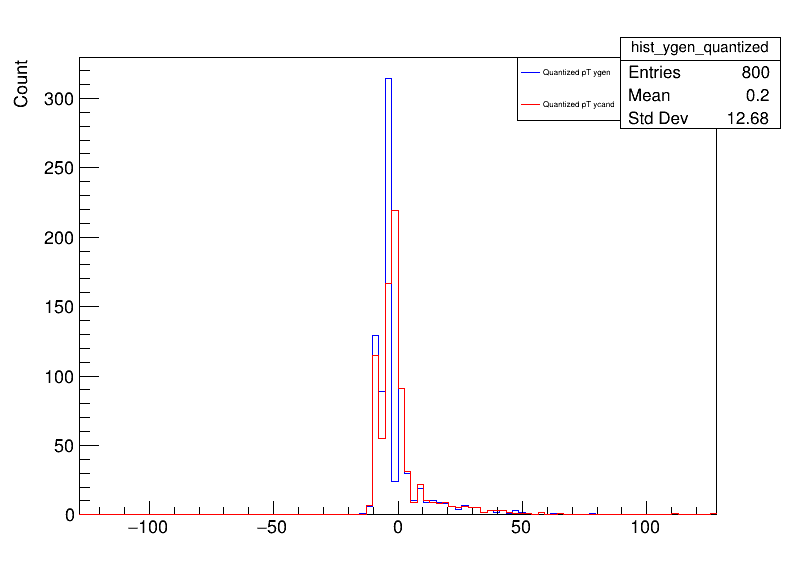

In [35]:
hist_ygen_quantized = ROOT.TH1F("hist_ygen_quantized", "", 100, -128, 128)
hist_ycand_quantized = ROOT.TH1F("hist_ycand_quantized", "Quantized Standardized True pt from ycand", 100, -128, 128)

# Fill histograms with quantized standardized 'pt' values
for value in quantized_true_pts_ygen:
    hist_ygen_quantized.Fill(value)

for value in quantized_true_pts_ycand:
    hist_ycand_quantized.Fill(value)
    
    
# Create canvas and draw histograms
canvas_quantized = ROOT.TCanvas("canvas_quantized", "Quantized Standardized True pt Comparison", 800, 600)

hist_ygen_quantized.Draw()
# hist_ygen_quantized.SetTitle("Quantized Standardized True pt Comparison")
hist_ygen_quantized.SetLineColor(ROOT.kBlue)
# hist_ygen_quantized.GetXaxis().SetTitle("Quantized pt")
hist_ygen_quantized.GetYaxis().SetTitle("Count")

hist_ycand_quantized.Draw("SAME")
hist_ycand_quantized.SetLineColor(ROOT.kRed)

# Add a legend
legend_quantized = ROOT.TLegend(0.65, 0.79, 0.78, 0.9)
legend_quantized.AddEntry(hist_ygen_quantized, "Quantized pT ygen", "l")
legend_quantized.AddEntry(hist_ycand_quantized, "Quantized pT ycand", "l")
legend_quantized.Draw("SAME")

# Show the canvas
canvas_quantized.Draw()

As model is already quantized, for this variable we can quantize it again.


In [37]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_models_dir = pathlib.Path("/tmp/working1_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_file = tflite_models_dir/"working1_tflite_models.tflite"
tflite_model_file.write_bytes(tflite_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"working_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

5963072

2024-01-20 10:35:14.281770: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-01-20 10:35:14.281801: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-01-20 10:35:14.282961: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/sraj/tmp46utkdzc
2024-01-20 10:35:14.324750: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-01-20 10:35:14.324791: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/sraj/tmp46utkdzc
2024-01-20 10:35:14.443000: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-01-20 10:35:14.503345: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-01-20 10:35:15.127506: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/sraj/tmp4

In [38]:
ls -lh {tflite_models_dir}

total 27M
-rw-r--r--. 1 sraj zh  22M Jan 20 10:35 working1_tflite_models.tflite
-rw-r--r--. 1 sraj zh 5.7M Jan 20 10:36 working_model_quant.tflite


In [39]:
# Load the model into an interpreter
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [40]:

interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()

In [33]:
#Print Expected Input Shape:
print("Expected Input Shape:", interpreter_quant.get_input_details()[0]['shape'])


Expected Input Shape: [  1 111  17]


In [34]:
# Load the quantized model into an interpreter
interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()

In [35]:
# Initialize lists to store true and predicted values
true_pts_quant = []
pred_pts_quant = []

In [36]:
# Iterate over batches in the quantized dataset
for ibatch in range(len(Xs)):
    # Quantize input data
    quantized_input_data = quantize_input(Xs[ibatch], scale_factor)  # Replace with the appropriate function

    # Set the input tensor
    input_tensor_index = interpreter_quant.get_input_details()[0]['index']
    interpreter_quant.tensor(input_tensor_index)()[0] = quantized_input_data

    # Run inference
    interpreter_quant.invoke()

    # Get the output tensor
    output_tensor_index = interpreter_quant.get_output_details()[0]['index']
    pred_pt_quant = interpreter_quant.tensor(output_tensor_index)()[0]

    # Dequantize the predicted values if needed
    pred_pt_quant = dequantize_output(pred_pt_quant, scale_factor)  # Replace with the appropriate function

    # Extract true values from the quantized dataset
    mask_true_particles_quant = ys[ibatch][..., 0] != 0
    true_pt_quant = ys[ibatch][mask_true_particles_quant, 2]

    # Append true and predicted values to the lists
    true_pts_quant.append(true_pt_quant)
    pred_pts_quant.append(pred_pt_quant)

NameError: name 'quantize_input' is not defined

In [43]:
print("Current Input Data Shape:", input_data.shape)


NameError: name 'input_data' is not defined

In [ ]:

# Reshape and pad the input data
padded_input_data = np.pad(input_data, ((0, 111 - 65), (0, 0)), mode='constant', constant_values=0)
# Truncate the input data
truncated_input_data = input_data[:111, :]


In [46]:
# Reshape the input data to match the expected shape
input_data = np.reshape(input_data, (1, 111, 17))
# Perform quantized inference
interpreter_quant.set_tensor(input_details_quant['index'], input_data)
interpreter_quant.invoke()
output_data = interpreter_quant.get_tensor(interpreter_quant.get_output_details()[0]['index'])


NameError: name 'input_data' is not defined

In [45]:
# Assuming output_data contains the predicted pt values from quantized inference

true_pts_quantized = []
pred_pts_quantized = []

# Print the shape of output_data
print("Output Data Shape:", output_data.shape)

# Iterate through the data
for ibatch in range(len(Xs)):
    ret = model(Xs[ibatch])

    mask_true_particles = ys[ibatch][..., 0] != 0
    
    true_pt = ys[ibatch][mask_true_particles, 2]
    
    # Adjust the indexing based on the actual shape of output_data
    pred_pt_quantized = output_data[0, ibatch, 0]  # Assuming the output_data has shape (1, len(Xs), 1)

    true_pts_quantized.append(true_pt)
    pred_pts_quantized.append(pred_pt_quantized)


NameError: name 'output_data' is not defined

In [ ]:

# Plot the histogram directly without explicit concatenation
plt.hist([pred_pt_quantized, true_pt_quantized], bins=np.linspace(0, 3, 100), label=['Predicted', 'True'], density=True)
plt.yscale("log")
plt.xlabel("Predicted True Pt Ratio")
plt.ylabel("Count (Normalized)")
plt.title("Histogram of Predicted True Pt Ratio from Quantized Inference")
plt.legend()
plt.show()
